#http://localhost:8889/lab/tree/whatcouldgowrong.ipynb Implementing and using iterable datasets: What Could Go Wrong?


**Goal**: Understand different issues *users* have to deal with when they use **iterable** datasets. *Users* = us, as domain libs authors; and also our downstream users.

**Why is this relevant to us?**  Because datapipes are planned to be first-class citizens of the PyTorch data loading ecosystem. Datapipes **are** iterable datasets so everything we'll discuss is relevant for datapipes as well. For now, these issues aren't addressed.

**Disclaimer**: this talk might be confusing. It's actually the point (kinda).


## Let's start with the basics

#### Map-style datasets

In [1]:
import torch
import torch.utils.data as data


class MyMapStyleDS:
    
    def __init__(self, size=100):
        self.size = size
        
    def __getitem__(self, i):  # Returns the i'th sample
        # Here: read from disk [+ decoding] [+ transforms]
        s = i
        return s
    
    def __len__(self):
        return self.size
    
    
mapstyle_ds = MyMapStyleDS()
mapstyle_dl = data.DataLoader(mapstyle_ds, batch_size=10)

for batch in mapstyle_dl:
    print(batch)
    # Here: forward and backward passes

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
tensor([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
tensor([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
tensor([40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
tensor([50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
tensor([60, 61, 62, 63, 64, 65, 66, 67, 68, 69])
tensor([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])
tensor([80, 81, 82, 83, 84, 85, 86, 87, 88, 89])
tensor([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])


#### Iterable datasets

In [2]:
class MyIterableDS(data.IterableDataset):
    
    def __init__(self, size=100):
        self.size = size
        
    def __iter__(self):  # iterate over samples
        # Here: read from disk [+ decoding] [+ transforms]
        for s in range(self.size):
            yield s
    
    def __len__(self):
        return self.size
    
    
iter_ds = MyIterableDS()
iter_dl = data.DataLoader(iter_ds, batch_size=10)

for batch in iter_dl:
    print(batch)
    # Here: forward and backward passes

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
tensor([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
tensor([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
tensor([40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
tensor([50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
tensor([60, 61, 62, 63, 64, 65, 66, 67, 68, 69])
tensor([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])
tensor([80, 81, 82, 83, 84, 85, 86, 87, 88, 89])
tensor([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])


### So far so good
## Let's add some parallelism <o/

We'll cover:

- DataLoader parallelism
- DDP parallelism

Fun fact: they're not mutually exclusive



### DataLoader parallelism

#### Map-style - EZPZ lemon squeezy

In [3]:
mapstyle_dl = data.DataLoader(mapstyle_ds, batch_size=10, num_workers=4)

for batch in mapstyle_dl:
    print(batch)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
tensor([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
tensor([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
tensor([40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
tensor([50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
tensor([60, 61, 62, 63, 64, 65, 66, 67, 68, 69])
tensor([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])
tensor([80, 81, 82, 83, 84, 85, 86, 87, 88, 89])
tensor([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])


#### Iterable - ~EZPZ lemon squeezy~

In [4]:
iter_dl = data.DataLoader(iter_ds, batch_size=10, num_workers=5)

for batch in iter_dl:
    print(batch)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
tensor([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
tensor([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
tensor([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
tensor([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
tensor([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
tensor([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
tensor([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
tensor([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
tensor([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
tensor([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
tensor([40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
tensor([40, 41, 42, 4

### Oops. What went wrong?


Let's dive into the DataLoader internals.

<img src="imgs/DL.jpg" width="500"/>

What we have: all workers see the same data

<img src="imgs/dataset_basic.svg" width="300"/>


What we want: some sharding

<img src="imgs/dataset_sharded.svg" width="300"/>



- **Map-style dataset**: main DataLoader process is able to request specific indices from each worker
- **Iterable dataset**: there's no notion of "indices". All the DataLoader can do is to request the "next" sampler from each worker, via `None`.
  - So we need to tell each worker which samples belong to them.
  - We have to do that **manually**.
  - There's no standard or cannonical way.
  
 
TL;DR: it's hard 🥲


In [5]:
class MyIterableDS(data.IterableDataset):
    
    def __init__(self, size=100):
        self.size = size
        
    def __iter__(self):  # iterate over samples
        worker_info = data.get_worker_info()
        num_workers = worker_info.num_workers
        worker_id = worker_info.id
        
        for i, s in enumerate(range(self.size)):
            if i % num_workers == worker_id:
                yield s
    
    def __len__(self):
        return self.size
    
    
iter_ds = MyIterableDS()
iter_dl = data.DataLoader(iter_ds, batch_size=10, num_workers=4)

for batch in iter_dl:
    print(batch)

tensor([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36])
tensor([ 1,  5,  9, 13, 17, 21, 25, 29, 33, 37])
tensor([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38])
tensor([ 3,  7, 11, 15, 19, 23, 27, 31, 35, 39])
tensor([40, 44, 48, 52, 56, 60, 64, 68, 72, 76])
tensor([41, 45, 49, 53, 57, 61, 65, 69, 73, 77])
tensor([42, 46, 50, 54, 58, 62, 66, 70, 74, 78])
tensor([43, 47, 51, 55, 59, 63, 67, 71, 75, 79])
tensor([80, 84, 88, 92, 96])
tensor([81, 85, 89, 93, 97])
tensor([82, 86, 90, 94, 98])
tensor([83, 87, 91, 95, 99])


Works OK, but:

- Manual and boilerplate code, and there's no standard
- Notice the difference with Map-style Dataset (not a big deal tho)
- **Notice the batch size at the end!!**. This can have [bad consequences](https://github.com/pytorch/data/issues/302) when batch-norm is involved. Solution: use `drop_last=True`; but ideally we shouldn't need to.

#### Now let's take a look at DDP parallelism

What is DDP (Distributed Data Parallel)?
- N copies of the model, typically on N GPUs (== N DDP processes).
- The N models see different parts of the data  <-- **That's the important part**
- The N models' weights are kept equal via gradient synchronization


<img src="https://www.telesens.co/wp-content/uploads/2017/12/img_5a416615431e7.png" width="500"/>

(Image source: https://www.telesens.co/2017/12/25/understanding-data-parallelism-in-machine-learning/)


Let's look at this outside of this notebook (if we have time)

\<insert pain here\>

TL;DR:

- The exact same sharding issue happens (but for other reasons)
- So we need to shard across **DDP workers** (just like we sharded across DataLoader workers above)
- DataLoader multi-processing can be embedded within a DDP multi-process:
  - **So we need 2 levels of sharding**: DDP *and* DataLoader:

In [6]:
class MyIterableDS(data.IterableDataset):
    
    def __init__(self, size=100):
        self.size = size
        
    def __iter__(self):  # iterate over samples
        
        worker_info = data.get_worker_info()
        num_dl_workers = worker_info.num_workers
        dl_worker_id = worker_info.id

        num_ddp_workers = dist.get_world_size()
        ddp_worker_id = dist.get_rank()
        
        for i, s in enumerate(range(self.size)):  # We need 2 levels of sharding!!
            if i % num_ddp_workers == ddp_worker_id:
                if i % num_dl_workers == dl_worker_id:
                    yield s
    
    def __len__(self):
        return self.size

But IRL you'll need a lot of glue code (e.g. only shard when DDP is on).
And with datapipes, these 2 sharding filters can happen at different stages of the pipeline, which complicates things.

## More fun: shuffling

#### Map-style: EZPZ lemon squeezy

In [7]:
sampler = data.RandomSampler(mapstyle_ds)
mapstyle_dl = data.DataLoader(mapstyle_ds, batch_size=10, num_workers=4, sampler=sampler)

for batch in mapstyle_dl:
    print(batch)

tensor([95, 94, 74, 63,  4, 86, 55, 58, 50, 39])
tensor([76, 51, 48, 52,  0, 67, 20, 57, 23, 10])
tensor([18, 71, 17, 24, 93, 45, 33,  3, 81, 87])
tensor([ 1, 27, 46, 15, 91, 47, 54, 85, 66, 49])
tensor([64, 88, 68, 56, 59, 12, 69, 14, 83, 75])
tensor([98, 34, 78, 99, 77, 32,  7, 13,  9, 97])
tensor([70,  8, 30, 36, 41, 90, 16, 73, 65, 92])
tensor([42, 79, 53, 29, 35, 26, 40, 61, 19,  5])
tensor([89, 31, 44, 21, 80, 82, 11,  2, 43, 37])
tensor([28, 84, 22, 96, 60,  6, 25, 62, 38, 72])


#### Iterable: ~EZPZ lemon squeezy~

In [8]:
sampler = data.RandomSampler(iter_ds)
iter_ds = MyIterableDS()
# Samplers aren't allows, this raises an error:
# iter_dl = data.DataLoader(iter_ds, batch_size=10, num_workers=4, sampler=sampler)

#### OK, let's shuffle manually then

In [9]:
import random

class MyIterableDS(data.IterableDataset):
    
    def __init__(self, size=100):
        self.size = size
        
    def __iter__(self):  # iterate over samples
        worker_info = data.get_worker_info()
        num_workers = worker_info.num_workers
        worker_id = worker_info.id
        
        buffer = []
        
        for i, s in enumerate(range(self.size)):
            if i % num_workers == worker_id:
                buffer.append(s)
        
        random.shuffle(buffer)
        
        yield from buffer
    
    def __len__(self):
        return self.size

iter_ds = MyIterableDS()
iter_dl = data.DataLoader(iter_ds, batch_size=10, num_workers=4)

for batch in iter_dl:
    print(batch)

tensor([20, 12, 72, 36, 80,  4,  0, 28, 92, 84])
tensor([73, 53, 65, 21, 85, 17, 45, 57, 29,  5])
tensor([26, 66, 90, 14, 10, 54, 82, 74, 62, 22])
tensor([43, 39, 79, 51, 87, 83, 19, 59, 47, 63])
tensor([40,  8, 96, 60, 16, 52, 48, 56, 76, 32])
tensor([97, 41, 89, 61, 33, 81, 77, 49, 25, 37])
tensor([ 6, 78, 50,  2, 34, 70, 38, 98, 58, 42])
tensor([67, 31, 75,  7, 99, 95, 23, 55,  3, 27])
tensor([68, 64, 44, 88, 24])
tensor([ 1,  9, 13, 69, 93])
tensor([30, 86, 46, 94, 18])
tensor([91, 15, 71, 11, 35])


#### Looks random 🤩

Narrator: *It's not*

And it's **not obvious** to diagnose. Each individual worker is only shuffling **within its own shard** (the green bits).

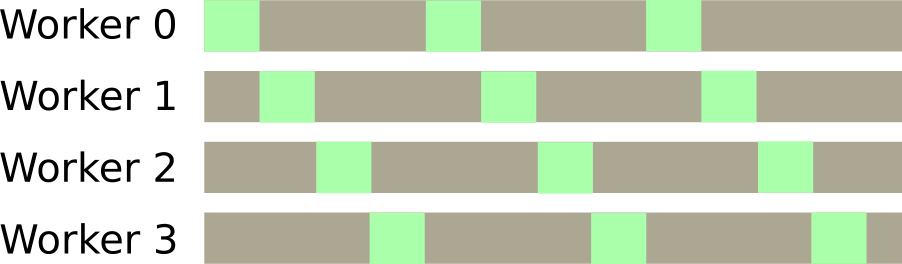

That's not uniform shuffling: the same samples are always being batched together. It can have dramatic effects on the accuracy, especially when the underlying files are stored in a per-class folder structure.

**We need to shuffle before we shard**. So let's do that:

In [10]:
import torch
import torch.utils.data as data
import random

class MyIterableDS(data.IterableDataset):
    
    def __init__(self, size=100):
        self.size = size
        
    def __iter__(self):  # iterate over samples
        worker_info = data.get_worker_info()
        num_workers = worker_info.num_workers
        worker_id = worker_info.id
        
        buffer = []
        for s in range(self.size):
            buffer.append(s)
                
        random.shuffle(buffer)
        
        for i, s in enumerate(buffer):
            if i % num_workers == worker_id:
                yield s
    
    def __len__(self):
        return self.size

iter_ds = MyIterableDS()
iter_dl = data.DataLoader(iter_ds, batch_size=10, num_workers=4)

batches = []
for batch in iter_dl:
    print(batch)
    batches.append(batch)

tensor([82, 93, 84,  6, 94, 51, 96, 48, 14, 66])
tensor([74, 87, 75, 27, 92, 50, 96, 45, 39, 35])
tensor([69, 32,  8, 85,  0, 96, 27, 71, 94, 91])
tensor([92, 28, 32, 90, 80, 79,  2, 77, 48, 60])
tensor([80,  8, 36, 85, 77, 79,  1, 53, 27, 41])
tensor([68, 71, 82,  5,  3,  4, 51, 79, 84, 41])
tensor([43, 14,  9,  1, 92, 82, 77, 76, 67, 30])
tensor([15, 51, 97, 20, 66, 54, 57, 74, 24, 21])
tensor([29, 16,  5, 44, 63])
tensor([55, 48, 69, 46,  2])
tensor([19, 26, 53, 23, 68])
tensor([78, 40, 98,  6, 75])


#### Did it work now? 🤩


Narrator: *it didn't*

In [11]:
all_samples = torch.cat(batches)
_, counts = torch.unique(all_samples, return_counts=True)
counts, counts.shape

(tensor([1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1,
         1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 3, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2,
         1, 3, 1, 3, 2, 3, 2, 2, 1, 1, 1, 3, 1, 2, 3, 1, 1]),
 torch.Size([65]))

**Reason**: all workers use a [different RNG seed](https://github.com/pytorch/pytorch/blob/3ac27e78ca5429b47a63826a1bb678031d20bffd/torch/utils/data/_utils/worker.py#L217-L223) for shuffling, so some samples can be missing or duplicated.

#### So we need the same RNG seed across workers 🤓. Phew!!

Narrator: *still no*.

We don't want that either: we still want the RNG of the sample transformations (done within the workers) to be different.

We **only** want the seed for **shuffling** to be the same across workers (meaning: across DataLoader workers **and** DDP workers).

Idea: pass the shuffling seed in `__init__()`. But **be careful**: we still need to make sure the seed will be different across epochs (remember [`DistributedSampler.set_epoch()`](https://github.com/pytorch/pytorch/blob/401179f263d5ba22731de107874f41fdd256737f/torch/utils/data/distributed.py#L100)?)

TL;DR: it's hard 🥲

*The implementation of an iterable dataset that properly handles DDP and DataLoader multiprocessing, shuffling and sharding, all within a simple user-friendly API that does not expose low-level implementation details, is left as an exercise to the reader.*

## Take away:

We've seen a bunch of issues with iterable datasets:
  - Related to sharding / multiprocessing
    - inside the DataLoader
    - outside the DataLoader (DDP)
    - when both are involved
  - Related to shuffling
  - Related to the *order* of these operation: shuffling before sharding

Hopefully, you're confused. It is confusing! **We cannot expect our users to understand all this**.



One of the torchdata's team KR for H1 is adoption of datapipes by torchvision and torchtext. Hopefully (but this *still* needs to be benchmarked), datapipes provide a unified way to access internal (manifold) and external resources. Before we can adopt datapipes:

### We need **cannonical, high-level, robust APIs** that will prevent users from falling into all these traps.

 The torchdata team is working on open-sourcing DataLoaderV2. We need to make sure these problems are addressed in DataLoaderV2.